In [1]:
import pandas as pd

In [2]:
#load demographics (which we will merge in to each vol table later
df_demog = (pd
            .read_table('resources/subjects_HCA.csv',sep=',')
            .assign(age = lambda df_: df_.interview_age/12.0)
            .assign(subject = lambda df_: 'sub-' + df_.subject.astype(str))            
           )

      
methods = ['freesurfer','ashs',
               'hippunfold-t1-freesurferatlas','hippunfold-t1-magdeburgatlas','hippunfold-t1-bigbrainatlas']
methods_abbr = ['FS','ASHS',
                       'HippUnfold-FSatlas','HippUnfold-ASHSatlas','HippUnfold']

id_cols = ['subject','hemi','age','sex']

luts = {'freesurfer': 'resources/freesurfer_v21_CA_subfields_dseg.tsv',
        'ashs': 'resources/desc-subfields_atlas-magdeburg_dseg.tsv',
        'hippunfold-t1-freesurferatlas': 'resources/hippunfold_desc-subfields_atlas-freesurfer_dseg.tsv',
        'hippunfold-t1-magdeburgatlas': 'resources/hippunfold_desc-subfields_atlas-magdeburg_dseg.tsv',
        'hippunfold-t1-bigbrainatlas': 'resources/hippunfold_desc-subfields_atlas-bigbrain_dseg.tsv'}
               
all_subfields = { method: pd.read_table(luts[method]).abbreviation.to_list() for method in methods }



    
df = pd.concat( [(pd
            .read_table(f'results/{method}_volumes.tsv') #read table
            .merge(df_demog,on='subject')  # merge in demographics
            .melt(id_vars=id_cols,value_vars=all_subfields[method],var_name='subfield',value_name='volume')  #convert from wide to tidy
            .assign(method = lambda df_:abbr)  #add a column for the method
           )
            for method,abbr in zip(methods,methods_abbr) ]   #concatenate all the tidy tables 
         )

#remove the two subjects where Freesurfer failed
df = df.query("subject != 'sub-9578406' and subject != 'sub-7175272'")
df = df.reset_index()

df.sample(20)
    
    

,index,subject,hemi,age,sex,subfield,volume,method
6960,1094,sub-9646699,L,53.250000,F,DG,115.432220,HippUnfold
6010,124,sub-9646699,L,53.250000,F,Sub,422.624807,HippUnfold
4331,1707,sub-6117051,R,57.416667,F,Cyst,78.456287,HippUnfold-FSatlas
5074,720,sub-9717999,L,71.833333,F,CA3,156.151026,HippUnfold-ASHSatlas
6999,1133,sub-8959211,R,63.750000,M,DG,121.152457,HippUnfold
2944,292,sub-7670989,L,41.583333,F,PreSub,281.495129,HippUnfold-FSatlas
2889,235,sub-7307768,R,56.500000,F,PreSub,258.368554,HippUnfold-FSatlas
636,650,sub-8502872,L,81.083333,F,CA1,689.201500,FS
5544,1200,sub-7777200,L,40.000000,F,SRLM,563.941992,HippUnfold-ASHSatlas
2744,86,sub-6604264,L,53.166667,F,ParaSub,4.255975,HippUnfold-FSatlas


## Bland-altman plots

In [3]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

def plot_bland_altman(df,methods1,methods2,subfields,figsize=(18,16)):

    plt.tight_layout()
    f, axs = plt.subplots(ncols=len(methods1),nrows=len(subfields), figsize=figsize, squeeze=False)
    
    for i,(method1,method2) in enumerate(zip(methods1,methods2)):
        for j,subfield in enumerate(subfields):

            m1 = (df
                  .query(f'subfield == "{subfield}" and method == "{method1}"')
                  .volume
                  .to_numpy()
                 )
            m2 = (df
                  .query(f'subfield == "{subfield}" and method == "{method2}"')
                  .volume
                 .to_numpy()
                 )    
            
            
            sm.graphics.mean_diff_plot(m1,m2,ax=axs[j][i])


    #add column and row labels:

    rows = subfields
    cols = [f'{method1} vs {method2}' for method1,method2 in zip(methods1,methods2) ]


    for ax, col in zip(axs[0], cols):
        ax.set_title(col,size='xx-large')

    for ax, row in zip(axs[:,0], rows):
        ax.set_ylabel(row, rotation=90, size='xx-large')

    if len(cols)>1:
        for j in range(1,len(cols)):
            for ax in axs[:,j]:
                ax.set_ylabel('')
    return f

<Figure size 432x288 with 0 Axes>

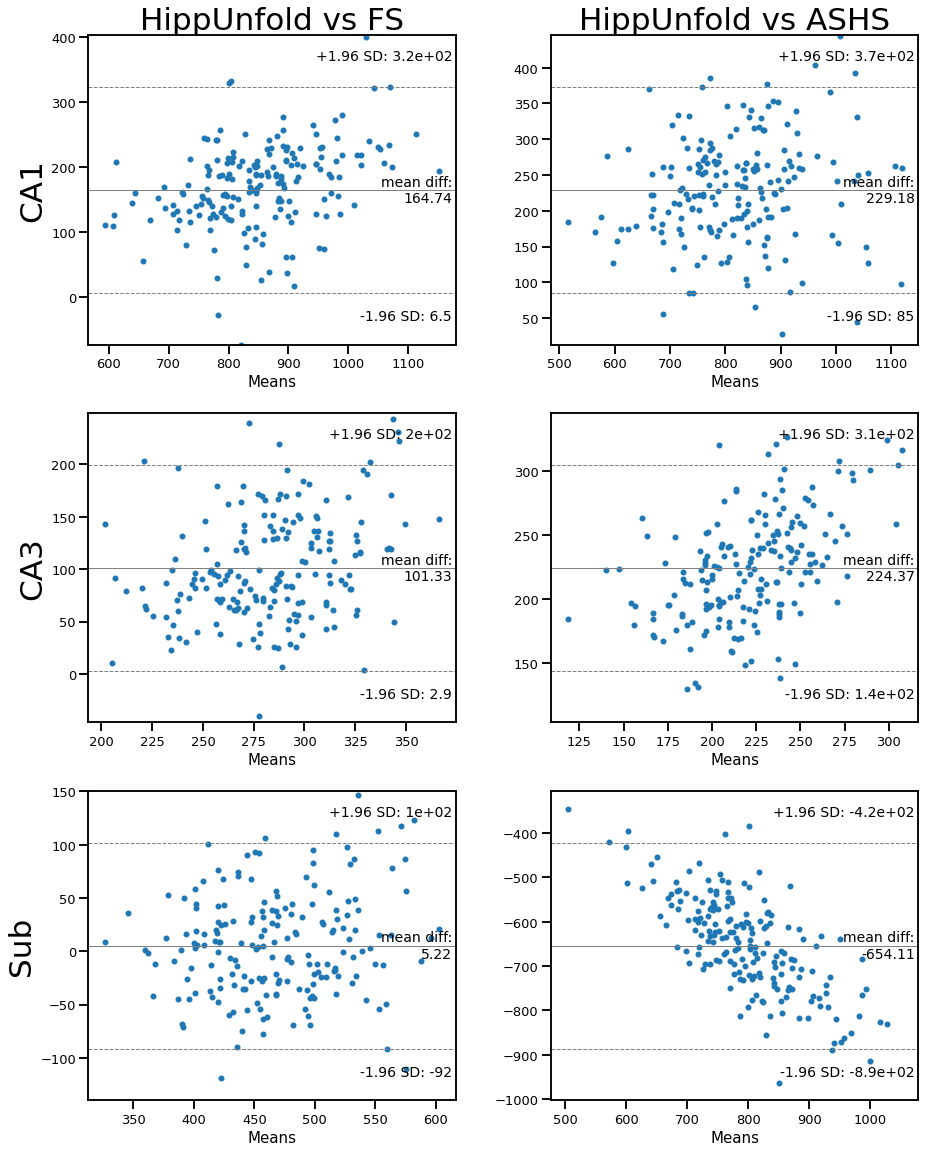

In [9]:
#compare hippunfold (T1) with FS and ASHS (using corresponding hippunfold atlases)

subfields = ['CA1','CA3','Sub']

methods1 = ['HippUnfold','HippUnfold']
methods2 = ['FS','ASHS']
fig1 = plot_bland_altman(df,methods1,methods2,subfields,figsize=(13,16))
fig1.savefig('figure_bland_altman.png',bbox_inches='tight',dpi=150)

## Vol vs Age plots

In [5]:
import seaborn as sns

sns.set_context('talk')
def plot_scatter(df,methods1,methods2,subfields,figsize=(15,15)):


    f, axs = plt.subplots(ncols=len(methods1),nrows=len(subfields), figsize=figsize,squeeze=False)


    for i,(method1,method2) in enumerate(zip(methods1,methods2)):
        for j,subfield in enumerate(subfields):

            sns.regplot(data=(df
                    .query(f'subfield == "{subfield}" and method == "{method1}"')
                             )
                            ,x='age',y='volume',ax=axs[j][i],label=method1)
            sns.regplot(data=(df
                    .query(f'subfield == "{subfield}" and method == "{method2}"')
                             )
                            ,x='age',y='volume',ax=axs[j][i],label=method2)        

            #axs[j,i].legend()

    #add column and row labels:

    rows = subfields
    cols = [f'{method1} vs {method2}' for method1,method2 in zip(methods1,methods2) ]


    for ax, col in zip(axs[0], cols):
        ax.set_title(col,size='xx-large')
        ax.legend()

    for ax, row in zip(axs[:,0], rows):
        ax.set_ylabel(row, rotation=90, size='xx-large')


    if len(cols)>1:
        for j in range(1,len(cols)):
            for ax in axs[:,j]:
                ax.set_ylabel('')
                
    if len(rows)>1:
        for i in range(0,len(rows)):
            for ax in axs[i,:]:
                ax.set_xlabel('')
            
        
    for ax in axs[len(rows)-1,:]:
        ax.set_xlabel('Age',size='xx-large')

        
    
    return f

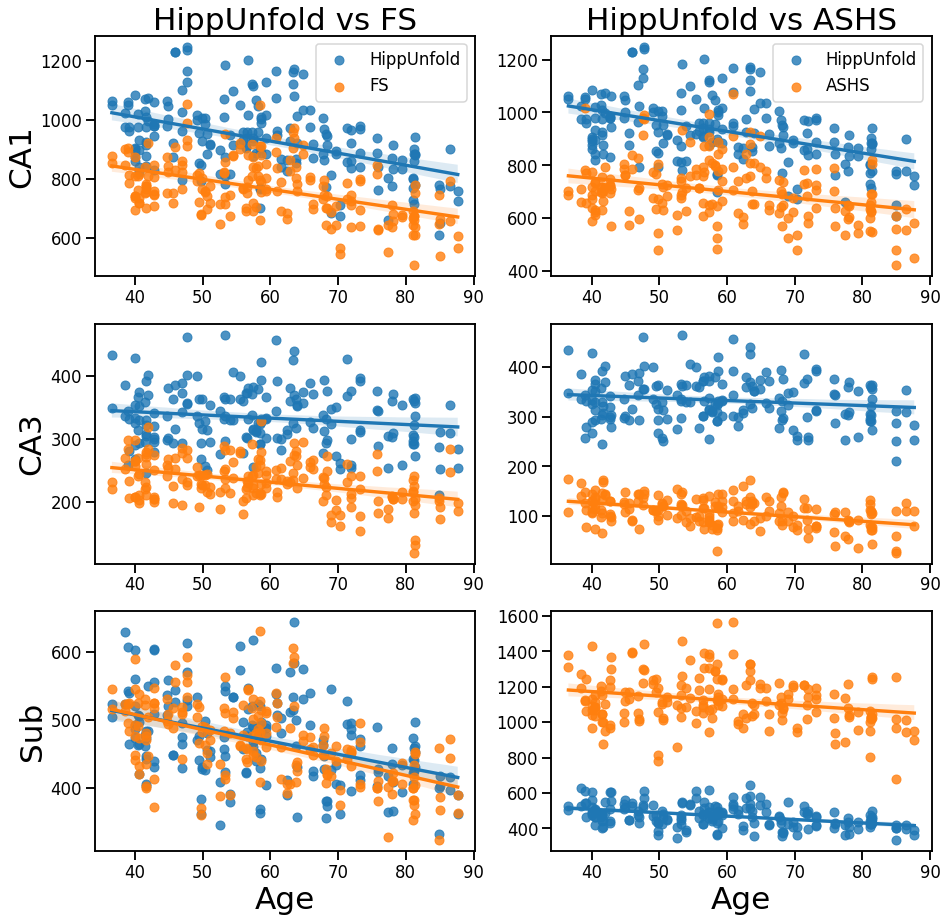

In [6]:
#compare hippunfold run on T1w (and various atlases) with FS and ASHS

methods1 = ['HippUnfold','HippUnfold']
methods2 = ['FS','ASHS']
subfields = ['CA1','CA3','Sub']

fig2 = plot_scatter(df,methods1,methods2,subfields)
fig2.savefig('figure_age_scatter.png',dpi=15)